/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.5022 - loss: 1.0257 - val_accuracy: 0.5344 - val_loss: 0.8178
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4724 - loss: 0.8066 - val_accuracy: 0.4941 - val_loss: 0.7556
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5174 - loss: 0.7570 - val_accuracy: 0.5344 - val_loss: 0.7352
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5138 - loss: 0.7481 - val_accuracy: 0.5558 - val_loss: 0.7266
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5951 - loss: 0.6813 - val_accuracy: 0.5226 - val_loss: 0.7272
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4682 - loss: 0.7261 - val_accuracy: 0.4608 - val_loss: 0.7417
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4969 - loss: 0.7378 - val_accuracy: 0.5131 - val_loss: 0.7299
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5458 - loss: 0.7012 - val_accuracy: 0.5463 - val_loss: 0.7287

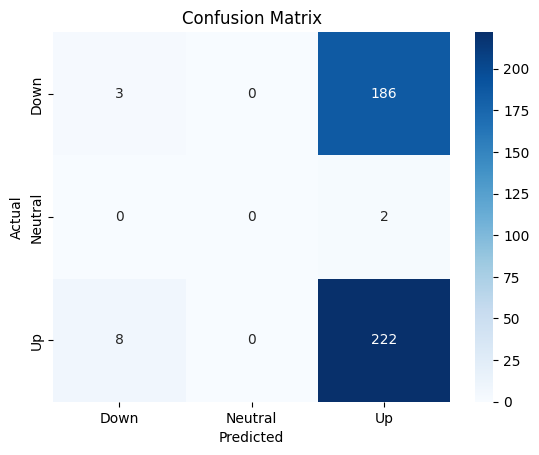

              precision    recall  f1-score   support

        Down       0.27      0.02      0.03       189
     Neutral       0.00      0.00      0.00         2
          Up       0.54      0.97      0.69       230

    accuracy                           0.53       421
   macro avg       0.27      0.33      0.24       421
weighted avg       0.42      0.53      0.39       421



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load the dataset
df = pd.read_csv("apple stocks.csv")

# Clean only numeric columns
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
df = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df = df.dropna()

df = df[numeric_cols].apply(pd.to_numeric, errors='coerce').dropna()

# Simple Moving Averages
df["SMA_20"] = df["Close"].rolling(window=20).mean()
df["SMA_50"] = df["Close"].rolling(window=50).mean()

# Exponential Moving Averages
df["EMA_10"] = df["Close"].ewm(span=10, adjust=False).mean()
df["EMA_20"] = df["Close"].ewm(span=20, adjust=False).mean()

# Momentum and Volatility
df["Momentum"] = df["Close"].diff(5)
df["Volatility"] = df["Close"].pct_change().rolling(5).std()

# Lag Features
df["Lag_1"] = df["Close"].shift(1)
df["Lag_2"] = df["Close"].shift(2)
df["Lag_3"] = df["Close"].shift(3)
df["Lag_5"] = df["Close"].shift(5)

# Volume Change and Price Range
df["Volume_Change"] = df["Volume"].pct_change()
df["Price_Range"] = df["High"] - df["Low"]

# RSI
delta = df["Close"].diff()
gain = delta.clip(lower=0).rolling(14).mean()
loss = -delta.clip(upper=0).rolling(14).mean()
rs = gain / loss
df["RSI"] = 100 - (100 / (1 + rs))

# VWAP
cum_vol = df["Volume"].cumsum()
cum_price_vol = (df["Close"] * df["Volume"]).cumsum()
df["VWAP"] = cum_price_vol / cum_vol

# MACD
ema12 = df["Close"].ewm(span=12, adjust=False).mean()
ema26 = df["Close"].ewm(span=26, adjust=False).mean()
macd = ema12 - ema26
macds = macd.ewm(span=9, adjust=False).mean()
macdh = macd - macds
df["MACD_12_26_9"] = macd
df["MACDs_12_26_9"] = macds
df["MACDh_12_26_9"] = macdh

# Stochastic Oscillator
low_14 = df["Low"].rolling(window=14).min()
high_14 = df["High"].rolling(window=14).max()
stoch_k = 100 * ((df["Close"] - low_14) / (high_14 - low_14))
stoch_d = stoch_k.rolling(window=3).mean()
df["STOCHk_14_3_3"] = stoch_k
df["STOCHd_14_3_3"] = stoch_d

# CCI
tp = (df["High"] + df["Low"] + df["Close"]) / 3
ma = tp.rolling(window=20).mean()
md = tp.rolling(window=20).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)
df["CCI"] = (tp - ma) / (0.015 * md)

# Williams %R
willr = -100 * ((high_14 - df["Close"]) / (high_14 - low_14))
df["WILLR"] = willr

# PPO
ppo_fast = df["Close"].ewm(span=12, adjust=False).mean()
ppo_slow = df["Close"].ewm(span=26, adjust=False).mean()
ppo = 100 * (ppo_fast - ppo_slow) / ppo_slow
ppo_signal = ppo.ewm(span=9, adjust=False).mean()
ppo_hist = ppo - ppo_signal
df["PPO_12_26_9"] = ppo
df["PPOs_12_26_9"] = ppo_signal
df["PPOh_12_26_9"] = ppo_hist

# PVO
vol_fast = df["Volume"].ewm(span=12, adjust=False).mean()
vol_slow = df["Volume"].ewm(span=26, adjust=False).mean()
pvo = 100 * (vol_fast - vol_slow) / vol_slow
pvo_signal = pvo.ewm(span=9, adjust=False).mean()
df["PVO_12_26_9"] = pvo
df["PVOs_12_26_9"] = pvo_signal
df["PVOh_12_26_9"] = pvo - pvo_signal

# TRIX
ema1 = df["Close"].ewm(span=14, adjust=False).mean()
ema2 = ema1.ewm(span=14, adjust=False).mean()
ema3 = ema2.ewm(span=14, adjust=False).mean()
trix = ema3.pct_change() * 100
df["TRIX_14_9"] = trix
df["TRIXs_14_9"] = trix.rolling(9).mean()

# ATR
tr1 = df["High"] - df["Low"]
tr2 = np.abs(df["High"] - df["Close"].shift(1))
tr3 = np.abs(df["Low"] - df["Close"].shift(1))
tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
df["ATR"] = tr.rolling(14).mean()

# CMF
mfv = ((df["Close"] - df["Low"]) - (df["High"] - df["Close"])) / (df["High"] - df["Low"]) * df["Volume"]
df["CMF"] = mfv.rolling(20).sum() / df["Volume"].rolling(20).sum()

# MASSI
hl = df["High"] - df["Low"]
ema1 = hl.ewm(span=9, adjust=False).mean()
ema2 = ema1.ewm(span=9, adjust=False).mean()
df["MASSI"] = (ema1 / ema2).rolling(window=25).sum()

# OBV
obv = [0]
for i in range(1, len(df)):
    if df["Close"].iloc[i] > df["Close"].iloc[i - 1]:
        obv.append(obv[-1] + df["Volume"].iloc[i])
    elif df["Close"].iloc[i] < df["Close"].iloc[i - 1]:
        obv.append(obv[-1] - df["Volume"].iloc[i])
    else:
        obv.append(obv[-1])
df["OBV"] = obv

# ROC
df["ROC"] = df["Close"].pct_change(periods=10) * 100

# EOM
distance = ((df["High"] + df["Low"]) / 2) - ((df["High"] + df["Low"]) / 2).shift(1)
box_ratio = (df["Volume"] / 1e6) / (df["High"] - df["Low"])
eom = distance / box_ratio
df["EOM"] = eom.rolling(14).mean()

# Ultimate Oscillator
bp = df["Close"] - np.minimum(df["Low"], df["Close"].shift(1))
tr = np.maximum(df["High"], df["Close"].shift(1)) - np.minimum(df["Low"], df["Close"].shift(1))
avg7 = bp.rolling(7).sum() / tr.rolling(7).sum()
avg14 = bp.rolling(14).sum() / tr.rolling(14).sum()
avg28 = bp.rolling(28).sum() / tr.rolling(28).sum()
df["ULT"] = 100 * (4 * avg7 + 2 * avg14 + avg28) / (4 + 2 + 1)



# Create label: 0 = down, 1 = neutral, 2 = up
df['Target'] = df['Close'].diff().shift(-1)
df['Target'] = df['Target'].apply(lambda x: 2 if x > 0 else (0 if x < 0 else 1))

# Drop rows with NaN created by diff/shift
df = df.dropna()

# Check if we have enough data left
if len(df) < 10:
    raise ValueError("Not enough data after cleaning. Please check the CSV or use a larger dataset.")

# Prepare features and labels
features = df.drop('Target', axis=1).values
labels = df['Target'].values.astype(int)

# Normalize features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Create time series sequences
time_steps = 10
X, y = [], []
for i in range(len(features_scaled) - time_steps):
    X.append(features_scaled[i:i+time_steps])
    y.append(labels[i+time_steps])

X, y = np.array(X), np.array(y)

# Check if sequences were created
if X.shape[0] == 0:
    raise ValueError("No sequences created. Try reducing the time_steps or ensure more rows remain after cleaning.")

# Split data (80% test, 20% train)
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Build the LSTM model
model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

# Evaluate model
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Accuracy and confusion matrix
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")

cm = confusion_matrix(y_test, y_pred)
labels_names = ['Down', 'Neutral', 'Up']
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels_names, yticklabels=labels_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred, target_names=labels_names))